# DDQN on CartPole-v1 Pytorch Implementation

In [1]:
"""Code copié de https://github.com/tqjxlm/Simple-DQN-Pytorch"""
import gym
import math
import random
import numpy as np
import time
import pickle

from copy import copy
from itertools import count
from collections import deque

env = gym.make('CartPole-v0').unwrapped

## Prepare

### Hyperparameters

In [2]:
model_name = 'Dueling_DDQN_Prior_Memory'
save_name = 'checkpoints/' + model_name
resume = False

class Config():

    def __init__(self):
        self.epsilon_start = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 10
        self.TARGET_UPDATE = 200
        self.BATCH_SIZE = 256
        self.start_from = 512
        self.GAMMA = 1
        self.dueling = True
        self.plot_every = 5
        self.lr = 3e-5
        self.optim_method = optim.Adam
        self.memory_size = 10000
        self.conv_layer_settings = [
            (3, 8, 5, 2),
            (8, 16, 5, 2),
            (16, 32, 5, 2),
            (32, 32, 5, 2)
        ]

### Memory

In [3]:
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Transition = namedtuple(
    'Transition', ['state', 'action', 'reward', 'next_state', 'terminal'])


class ReplayMemory(object):
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=10000):
        self.prob_alpha = alpha
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.frame = 1
        self.beta_start = beta_start
        self.beta_frames = beta_frames

    def beta_by_frame(self, frame_idx):
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)

    def push(self, transition):
        max_prio = self.priorities.max() if self.buffer else 1.0**self.prob_alpha

        total = len(self.buffer)
        if total < self.capacity:
            pos = total
            self.buffer.append(transition)
        else:
            prios = self.priorities[:total]
            probs = (1 - prios / prios.sum()) / (total - 1)
            pos = np.random.choice(total, 1, p=probs)

        self.priorities[pos] = max_prio

    def sample(self, batch_size):
        total = len(self.buffer)
        prios = self.priorities[:total]
        probs = prios / prios.sum()

        indices = np.random.choice(total, batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        beta = self.beta_by_frame(self.frame)
        self.frame += 1

        # Min of ALL probs, not just sampled probs
        prob_min = probs.min()
        max_weight = (prob_min*total)**(-beta)

        weights = (total * probs[indices]) ** (-beta)
        weights /= max_weight
        weights = torch.tensor(weights, device=device, dtype=torch.float)

        return samples, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = (prio + 1e-5)**self.prob_alpha

    def __len__(self):
        return len(self.buffer)

### Network

In [4]:
def init_params(net):

    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode='fan_out')
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, std=1e-3)
            init.constant_(m.bias, 0)


class ConvBlock(nn.Module):

    def __init__(self, input_size, output_size, kernel_size, stride):
        super(ConvBlock, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(
            input_size, output_size, kernel_size=kernel_size, stride=stride, padding=self.padding)
        self.bn = nn.BatchNorm2d(output_size)

    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))

    def size_out(self, size):
        return (size - self.kernel_size + self.padding * 2) // self.stride + 1


class DQN(nn.Module):

    def __init__(self, h, w, conv_layer_settings, dueling=False):
        super(DQN, self).__init__()
        self.dueling = dueling

        conv_blocks = []
        size = np.array([h, w])
        for s in conv_layer_settings:
            block = ConvBlock(s[0], s[1], s[2], s[3])
            conv_blocks.append(block)
            size = block.size_out(size)
        self.conv_step = nn.Sequential(*conv_blocks)
        linear_input_size = size[0] * size[1] * conv_layer_settings[-1][1]

        if self.dueling:
            self.adv = nn.Linear(linear_input_size, 2)
            self.val = nn.Linear(linear_input_size, 1)
        else:
            self.head = nn.Linear(linear_input_size, 2)

    def forward(self, x):
        x = self.conv_step(x)
        x = x.view(x.size(0), -1)

        if self.dueling:
            adv = F.relu(self.adv(x))
            val = F.relu(self.val(x))
            return val + adv - val.mean()
        else:
            return self.head(x)

### Renderer

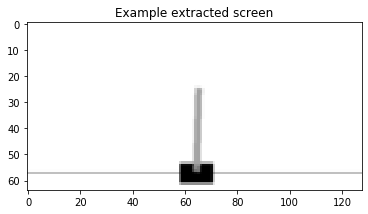

In [5]:
from threading import Event, Thread
import torchvision.transforms as T
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


resize = T.Compose([T.ToPILImage(),
                    T.CenterCrop((250, 500)),
                    T.Resize(64),
                    T.Grayscale(),
                    T.ToTensor()])


class RenderThread(Thread):
    # Usage:
    # 0. call env.step() or env.reset() to update env state
    # 1. call begin_render() to schedule a rendering task (non-blocking)
    # 2. call get_screen() to get the lastest scheduled result (block main thread if rendering not done)

    def __init__(self, env):
        super(RenderThread, self).__init__(target=self.render)
        self._stop_event = Event()
        self._state_event = Event()
        self._render_event = Event()
        self.env = env

    def stop(self):
        self._stop_event.set()
        self._state_event.set()

    def stopped(self):
        return self._stop_event.is_set()

    def begin_render(self):
        self._state_event.set()

    def get_screen(self):
        self._render_event.wait()
        self._render_event.clear()
        return self.screen

    def render(self):
        while not self.stopped():
            self._state_event.wait()
            self._state_event.clear()

            self.screen = self.env.render(
                mode='rgb_array').transpose((2, 0, 1))
            self.screen = np.ascontiguousarray(
                self.screen, dtype=np.float32) / 255
            self.screen = torch.from_numpy(self.screen)
            self.screen = resize(self.screen).unsqueeze(0).to(device)
            self._render_event.set()


# A simple test
renderer = RenderThread(env)
renderer.start()

env.reset()
renderer.begin_render()
screen = renderer.get_screen()

plt.figure()
plt.imshow(screen.cpu().squeeze(0).permute(
    1, 2, 0).numpy().squeeze(), cmap='gray')
plt.title('Example extracted screen')
plt.show()
renderer.stop()
renderer.join()

_, _, screen_height, screen_width = screen.shape

### History

In [6]:
class History():

    def __init__(self, plot_size=300, plot_every=5):
        self.plot_size = plot_size
        self.episode_durations = deque([], self.plot_size)
        self.means = deque([], self.plot_size)
        self.episode_loss = deque([], self.plot_size)
        self.indexes = deque([], self.plot_size)
        self.step_loss = []
        self.step_eps = []
        self.peak_reward = 0
        self.peak_mean = 0
        self.moving_avg = 0
        self.step_count = 0
        self.total_episode = 0
        self.plot_every = plot_every

    def update(self, t, episode_loss):
        self.episode_durations.append(t + 1)
        self.episode_loss.append(episode_loss / (t + 1))
        self.indexes.append(self.total_episode)
        if t + 1 > self.peak_reward:
            self.peak_reward = t + 1
        if len(self.episode_durations) >= 100:
            self.means.append(sum(list(self.episode_durations)[-100:]) / 100)
        else:
            self.moving_avg = self.moving_avg + \
                (t - self.moving_avg) / (self.total_episode + 1)
            self.means.append(self.moving_avg)
        if self.means[-1] > self.peak_mean:
            self.peak_mean = self.means[-1]

        if self.total_episode % self.plot_every == 0:
            self.plot()

    def plot(self):
        display.clear_output(wait=True)

        f, (ax1, ax3) = plt.subplots(1, 2, figsize=(14, 6))
        ax1.plot(self.indexes, self.episode_durations)
        ax1.plot(self.indexes, self.means)
        ax1.axhline(self.peak_reward, color='g')
        ax1.axhline(self.peak_mean, color='g')

        ax2 = ax1.twinx()
        ax2.plot(self.indexes, self.episode_loss, 'r')

        ax4 = ax3.twinx()
        total_step = len(self.step_loss)
        sample_rate = total_step // self.plot_size if total_step > (
            self.plot_size * 10) else 1
        ax3.set_title('total: {0}'.format(total_step))
        ax3.plot(self.step_eps[::sample_rate], 'g')
        ax4.plot(self.step_loss[::sample_rate], 'b')

        plt.pause(0.00001)

## Train

### Initialization and Hyperparameters
Run this cell if you want to start a fresh new training

In [7]:
# comment this out if a checkpoint is available
# load_name = 'checkpoints/checkpoint'

# Init network
if resume:
    print('loading checkpoint...')
    with open(save_name + '.pickle', 'rb') as f:
        data = pickle.load(f)
        history = data['history']
        config = data['config']

    checkpoint = torch.load(save_name + '.pt')

    policy_net = DQN(screen_height, screen_width,
                     config.conv_layer_settings).to(device)
    target_net = DQN(screen_height, screen_width,
                     config.conv_layer_settings).to(device)
    policy_net.load_state_dict(checkpoint['policy_net'])
    target_net.load_state_dict(checkpoint['target_net'])

    optimizer = config.optim_method(policy_net.parameters(), lr=config.lr)
    optimizer.load_state_dict(checkpoint['optimizer'])
else:
    print('fresh start...')
    history = History()
    config = Config()

    policy_net = DQN(screen_height, screen_width,
                     config.conv_layer_settings, config.dueling).to(device)
    target_net = DQN(screen_height, screen_width,
                     config.conv_layer_settings, config.dueling).to(device)
    init_params(policy_net)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = config.optim_method(policy_net.parameters(), lr=config.lr)

memory = ReplayMemory(config.memory_size)
target_net.eval()

fresh start...


DQN(
  (conv_step): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvBlock(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (adv): Linear(in_features=1024, out_features=2, bias=True)
  (val): Linear(in_features=1024, out_features=1, bias=True)
)

### Optimization Process

In [8]:
def optimize_model(step):
    if len(memory) < config.start_from:
        return 0

    if step % config.TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Sample memory as a batch
    samples, ids, weights = memory.sample(config.BATCH_SIZE)
    batch = Transition(*zip(*samples))

    # A tensor cannot be None, so strip out terminal states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Bellman's Equation
    with torch.no_grad():
        online_Q = policy_net(non_final_next_states)
        target_Q = target_net(non_final_next_states)
        next_Q = torch.zeros(config.BATCH_SIZE, device=device)
        next_Q[non_final_mask] = target_Q.gather(
            1, online_Q.max(1)[1].detach().unsqueeze(1)).squeeze(1)
        target_Q = next_Q * config.GAMMA + reward_batch

    # Compute loss
    policy_net.train()
    current_Q = policy_net(state_batch).gather(1, action_batch)
    diff = current_Q.squeeze() - target_Q
    loss = (0.5 * (diff * diff) * weights).mean()

    # Update memory
    delta = diff.abs().detach().cpu().numpy().tolist()
    memory.update_priorities(ids, delta)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.detach().cpu().numpy()


def epsilon_by_frame(frame_idx):
    return config.epsilon_final + \
        (config.epsilon_start - config.epsilon_final) * math.exp(-1. * frame_idx / config.epsilon_decay)


def select_action(state, eps):
    sample = random.random()
    if sample > eps:
        policy_net.eval()
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)

### Train Loop
This cell can be run multiple times without rerun the above cells.

Just change the loop size and you can continue training.

In [ ]:
renderer = RenderThread(env)
renderer.start()

for i_episode in range(10000):
    history.total_episode += 1

    env.reset()
    renderer.begin_render()

    init_screen = renderer.get_screen()
    screens = deque([init_screen] * 3, 3)
    state = torch.cat(list(screens), dim=1)
    avg_loss = 0

    for t in count():
        history.step_count += 1

        # Select and perform an action
        eps = epsilon_by_frame(history.total_episode)
        action = select_action(state, eps)
        history.step_eps.append(eps)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Render the step in another thread
        renderer.begin_render()

        # Do optimization in main thread
        loss = optimize_model(history.step_count)
        avg_loss += loss
        history.step_loss.append(loss)

        # Render the next_state and remember it
        screens.append(renderer.get_screen())
        next_state = torch.cat(list(screens), dim=1) if not done else None
        memory.push(Transition(state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        if done:
            history.update(t, avg_loss)
            break

renderer.stop()
renderer.join()

Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Users\Robert\anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\Robert\anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-5-aaed048d4c04>", line 53, in render
    mode='rgb_array').transpose((2, 0, 1))
  File "C:\Users\Robert\anaconda3\lib\site-packages\gym\envs\classic_control\cartpole.py", line 213, in render
    return self.viewer.render(return_rgb_array=mode == 'rgb_array')
  File "C:\Users\Robert\anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 104, in render
    glClearColor(1,1,1,1)
  File "C:\Users\Robert\anaconda3\lib\site-packages\pyglet\gl\lib.py", line 107, in errcheck
    raise GLException(msg)
pyglet.gl.lib.GLException: b'invalid operation'



## After Train

### Save

In [ ]:
torch.save({
    'policy_net': policy_net.state_dict(),
    'target_net': target_net.state_dict(),
    'optimizer': optimizer.state_dict()
}, save_name + '.pt')

with open(save_name + '.pickle', 'wb') as f:
    pickle.dump({'history': history, 'config': config},
                f, pickle.HIGHEST_PROTOCOL)

### Load

In [ ]:
with open(save_name + '.pickle', 'rb') as f:
    data = pickle.load(f)
    history = data['history']
    config = data['config']

checkpoint = torch.load(save_name + '.pt')
policy_net = DQN(screen_height, screen_width,
                 config.conv_layer_settings, config.dueling).to(device)
policy_net.load_state_dict(checkpoint['policy_net'])
policy_net.eval()

### Test

In [ ]:
renderer = RenderThread(env)
renderer.start()

for i in range(5):
    env.reset()
    renderer.begin_render()

    init_screen = renderer.get_screen()
    screens = deque([init_screen] * 3, 3)
    state = torch.cat(list(screens), dim=1)
    total_reward = 0

    while True:
        # Select and perform an action
        action = select_action(state, 0)
        _, reward, done, _ = env.step(action.item())
        total_reward += reward

        # Render the step in another thread
        renderer.begin_render()

        # Render the next_state and remember it
        screens.append(renderer.get_screen())
        next_state = torch.cat(list(screens), dim=1) if not done else None

        # Move to the next state
        state = next_state

        if done:
            print('total reward:', total_reward)
            break

renderer.stop()
renderer.join()